## Step 1: Problem Identification

#### Problem Statement: 
This project focuses on detecting anomalies in water distribution systems using the BATADAL (Battle of the Attack Detection ALgorithms) dataset. The dataset contains sensor readings from a water distribution network, including measurements of tank water levels, flow rates, pump statuses, and pressure values. The goal is to detect cyber-physical attacks and anomalies that could compromise the system's safety and efficiency.

#### Context:
Water distribution systems are critical infrastructure that must be protected against cyber-physical attacks and operational anomalies. These systems use SCADA (Supervisory Control and Data Acquisition) networks to monitor and control various components like pumps, valves, and tanks. Attackers may attempt to manipulate sensor readings or control systems, potentially leading to service disruption, equipment damage, or water quality issues.

The ability to detect anomalies in such systems is crucial for:
- Maintaining water supply reliability
- Protecting public health and safety
- Preventing equipment damage
- Optimizing system operations
- Detecting potential cyber-attacks early

#### Criteria For Success:
- Develop a model that can detect anomalies with high accuracy (target >90%)
- Minimize false positives while maintaining high detection rate
- Process time-series data in near real-time
- Provide interpretable results for operators

#### Scope of the Solution Space:
The project focuses on analyzing time-series data from multiple sensors in the water distribution network, including:
- Tank water levels (L_T1 to L_T7)
- Flow rates and pump statuses (F_PU1 to F_PU11, S_PU1 to S_PU11)
- Pressure measurements (P_J* sensors)
- Valve status and flow (F_V2, S_V2)

#### Constraints:
- Time-series nature of data requires special handling
- Need to handle multiple correlated sensors simultaneously
- Real-time processing requirements
- Balance between detection accuracy and false alarm rate

#### Data:
The dataset consists of two main files:
1. batadal_normal.csv: Contains normal operation data
2. batadal_attack.csv: Contains data with labeled attacks

Features include:
- DATETIME: Timestamp of measurements
- L_T*: Tank level measurements
- F_PU*, S_PU*: Pump flow and status readings
- P_J*: Junction pressure measurements
- F_V*, S_V*: Valve flow and status
- ATT_FLAG: Attack label (0 for normal, 1 for attack)

#### Solution Approach:
1. Data Preprocessing
   - Time series alignment
   - Missing value handling
   - Feature scaling

2. Feature Engineering
   - Temporal features
   - Statistical features
   - Domain-specific features

3. Model Development
   - Time series anomaly detection
   - Self-supervised learning approaches
   - Multiple sensor correlation analysis

4. Evaluation
   - Detection accuracy
   - False positive rate
   - Detection delay
   - Model interpretability

## Step 2: Data Wrangling

#### 2.1 -  Download the data ( DON'T RUN THE CODE IN NEXT LINE AFTER THE INITIAL RUN !!!)
First, download the data set from Kaggle page https://www.kaggle.com/nphantawee/pump-sensor-data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Read the normal and attack datasets
normal_data = pd.read_csv('../data/raw/batadal_normal.csv')
attack_data = pd.read_csv('../data/raw/batadal_attack.csv')

# Convert DATETIME to pandas datetime
normal_data['DATETIME'] = pd.to_datetime(normal_data['DATETIME'])
attack_data['DATETIME'] = pd.to_datetime(attack_data['DATETIME'])

# Set DATETIME as index
normal_data.set_index('DATETIME', inplace=True)
attack_data.set_index('DATETIME', inplace=True)

# Print basic information about the datasets
print("Normal Data Shape:", normal_data.shape)
print("Attack Data Shape:", attack_data.shape)
print("\nFeatures in the dataset:")
for col in normal_data.columns:
    print(f"- {col}")

# Display first few rows of normal data
print("\nFirst few rows of normal operation data:")
display(normal_data.head())

Dataset Shape: (4177, 45)

First few rows of the dataset:


,DATETIME,L_T1,L_T2,L_T3,L_T4,L_T5,L_T6,L_T7,F_PU1,S_PU1,...,P_J256,P_J289,P_J415,P_J302,P_J306,P_J307,P_J317,P_J14,P_J422,ATT_FLAG
0,2016-07-04T00:00:00.000000,2.44,5.24,3.19,4.10,2.86,5.50,4.39,93.63,1,...,70.00,28.22,85.87,21.69,82.72,21.58,71.99,39.33,29.64,0
1,2016-07-04T01:00:00.000000,2.66,4.53,3.20,4.18,3.29,5.44,4.53,89.41,1,...,87.73,24.45,84.87,29.81,86.62,29.81,59.76,42.17,26.15,0
2,2016-07-04T02:00:00.000000,3.11,3.66,3.66,4.21,3.87,5.15,3.22,89.88,1,...,89.29,23.90,87.11,29.85,87.64,29.85,58.50,42.00,25.56,0
3,2016-07-04T03:00:00.000000,3.62,3.04,4.17,4.04,3.56,4.98,2.40,88.10,1,...,91.98,27.10,68.75,31.60,64.25,31.47,72.30,43.24,28.38,0
4,2016-07-04T04:00:00.000000,4.08,2.68,4.73,3.20,3.11,5.39,3.46,87.01,1,...,92.11,26.76,68.74,32.30,64.23,32.17,72.53,44.00,28.04,0



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 45 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DATETIME  4177 non-null   object 
 1   L_T1      4177 non-null   float64
 2   L_T2      4177 non-null   float64
 3   L_T3      4177 non-null   float64
 4   L_T4      4177 non-null   float64
 5   L_T5      4177 non-null   float64
 6   L_T6      4177 non-null   float64
 7   L_T7      4177 non-null   float64
 8   F_PU1     4177 non-null   float64
 9   S_PU1     4177 non-null   int64  
 10  F_PU2     4177 non-null   float64
 11  S_PU2     4177 non-null   int64  
 12  F_PU3     4177 non-null   float64
 13  S_PU3     4177 non-null   int64  
 14  F_PU4     4177 non-null   float64
 15  S_PU4     4177 non-null   int64  
 16  F_PU5     4177 non-null   float64
 17  S_PU5     4177 non-null   int64  
 18  F_PU6     4177 non-null   float64
 19  S_PU6     4177 non-null   int64  
 20  F_PU7     4177 

<font color='teal'>**Unzip the zip file to extract CSV files in the working directory**</font>

In [1]:
# Separate features by type
try:
    # Tank level sensors (L_T*)
    tank_levels = [col for col in normal_data.columns if col.startswith('L_T')]
    print("Tank level sensors:", tank_levels)
    
    # Pump flow and status sensors (F_PU* and S_PU*)
    pump_flows = [col for col in normal_data.columns if col.startswith('F_PU')]
    pump_status = [col for col in normal_data.columns if col.startswith('S_PU')]
    print("\nPump flow sensors:", pump_flows)
    print("Pump status sensors:", pump_status)
    
    # Valve sensors (F_V* and S_V*)
    valve_data = [col for col in normal_data.columns if col.startswith(('F_V', 'S_V'))]
    print("\nValve sensors:", valve_data)
    
    # Pressure junction sensors (P_J*)
    pressure_data = [col for col in normal_data.columns if col.startswith('P_J')]
    print("\nPressure sensors:", pressure_data)
    
    print("\nTotal number of features by type:")
    print(f"Tank levels: {len(tank_levels)}")
    print(f"Pump flows: {len(pump_flows)}")
    print(f"Pump status: {len(pump_status)}")
    print(f"Valve data: {len(valve_data)}")
    print(f"Pressure data: {len(pressure_data)}")
except NameError:
    print("Error: Please run the data loading cell above first to create the 'normal_data' DataFrame")

NameError: name 'normal_data' is not defined

In [ ]:
# Set up the plotting style with error handling
try:
    plt.style.use('seaborn')
    plt.rcParams['figure.figsize'] = [15, 8]

    # Check if required variables exist
    required_vars = ['normal_data', 'tank_levels', 'pump_flows', 'pump_status', 'pressure_data']
    for var in required_vars:
        if var not in locals() and var not in globals():
            raise NameError(f"Variable '{var}' is not defined. Please run the data loading cells first.")

    # Plot tank levels over time
    plt.figure(figsize=(15, 10))
    for col in tank_levels:
        plt.plot(normal_data.index, normal_data[col], label=col)
    plt.title('Tank Levels Over Time (Normal Operation)')
    plt.xlabel('Time')
    plt.ylabel('Tank Level')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot pump flows and status
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # Plot pump flows
    for col in pump_flows[:5]:  # Plot first 5 pumps for clarity
        ax1.plot(normal_data.index, normal_data[col], label=col)
    ax1.set_title('Pump Flow Rates Over Time (First 5 Pumps)')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Flow Rate')
    ax1.legend()
    ax1.grid(True)

    # Plot pump status
    for col in pump_status[:5]:  # Plot first 5 pumps for clarity
        ax2.plot(normal_data.index, normal_data[col], label=col)
    ax2.set_title('Pump Status Over Time (First 5 Pumps)')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Status (0/1)')
    ax2.legend()
    ax2.grid(True)
    plt.tight_layout()
    plt.show()

    # Create correlation heatmap
    if len(pressure_data) > 0:
        plt.figure(figsize=(12, 10))
        correlation_matrix = normal_data[pressure_data].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Correlation between Pressure Measurements')
        plt.show()
    else:
        print("No pressure data available for correlation heatmap")

    # Compare normal vs attack patterns
    if 'attack_data' in locals() or 'attack_data' in globals():
        sensor = 'L_T1'  # Example with first tank level
        if sensor in normal_data.columns and sensor in attack_data.columns:
            plt.figure(figsize=(15, 6))
            plt.plot(normal_data.index, normal_data[sensor], label='Normal', alpha=0.7)
            plt.plot(attack_data.index, attack_data[sensor], label='Attack', alpha=0.7)
            plt.title(f'Comparison of {sensor} Readings: Normal vs Attack')
            plt.xlabel('Time')
            plt.ylabel('Tank Level')
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print(f"Sensor {sensor} not found in both datasets")
    else:
        print("Attack data not available for comparison")

except Exception as e:
    print(f"Error during visualization: {str(e)}")
    print("Please ensure all required data is loaded and preprocessed correctly.")

Dataset Info:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16973 entries, 0 to 16972
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  16973 non-null  int64  
 1   L_1        16973 non-null  float64
 2   L_2        16973 non-null  float64
 3   A_1        16973 non-null  float64
 4   A_2        16973 non-null  float64
 5   B_1        16973 non-null  float64
 6   B_2        16973 non-null  float64
 7   C_1        16973 non-null  float64
 8   C_2        16973 non-null  float64
 9   A_3        16973 non-null  float64
 10  A_4        16973 non-null  float64
 11  B_3        16973 non-null  float64
 12  B_4        16973 non-null  float64
 13  C_3        16973 non-null  float64
 14  C_4        16973 non-null  float64
 15  L_3        16973 non-null  float64
 16  L_4        16973 non-null  float64
 17  L_5        16973 non-null  float64
 18  L_6        16973 non-

### Feature Engineering for Water Distribution System Analysis

For water distribution systems, we need to create features that capture:
1. Temporal patterns in sensor readings
2. System state changes
3. Relationships between different components
4. Operating conditions that might indicate attacks

In [ ]:
# Create features for water distribution system analysis
def create_wds_features(df, name="dataset"):
    """
    Create features for water distribution system analysis with error handling
    """
    try:
        if not isinstance(df, pd.DataFrame):
            raise TypeError(f"Input must be a pandas DataFrame, got {type(df)}")
        
        if df.empty:
            raise ValueError("Input DataFrame is empty")
            
        df = df.copy()
        
        # 1. Rolling statistics for each sensor type
        window_sizes = [3, 6, 12]  # 3, 6, and 12 hour windows
        
        for window in window_sizes:
            # Tank level features
            for col in tank_levels:
                if col in df.columns:
                    df[f'{col}_rolling_mean_{window}h'] = df[col].rolling(window=window).mean()
                    df[f'{col}_rolling_std_{window}h'] = df[col].rolling(window=window).std()
            
            # Pressure features
            for col in pressure_data:
                if col in df.columns:
                    df[f'{col}_rolling_mean_{window}h'] = df[col].rolling(window=window).mean()
                    df[f'{col}_rolling_std_{window}h'] = df[col].rolling(window=window).std()
        
        # 2. Pump state changes
        for col in pump_status:
            if col in df.columns:
                df[f'{col}_state_change'] = df[col].diff().abs()
        
        # 3. Flow vs Status consistency check
        for i in range(1, 12):  # For each pump
            flow_col = f'F_PU{i}'
            status_col = f'S_PU{i}'
            if flow_col in df.columns and status_col in df.columns:
                # Flag when there's flow but pump is off, or no flow but pump is on
                df[f'pump_{i}_inconsistency'] = ((df[flow_col] > 0) & (df[status_col] == 0)) | \
                                              ((df[flow_col] == 0) & (df[status_col] == 1))
        
        # 4. Tank level rate of change
        for col in tank_levels:
            if col in df.columns:
                df[f'{col}_rate_of_change'] = df[col].diff()
        
        # 5. Pressure differences between connected junctions
        pressure_pairs = [
            ('P_J280', 'P_J269'),
            ('P_J300', 'P_J256'),
            ('P_J289', 'P_J415'),
            ('P_J302', 'P_J306'),
            ('P_J307', 'P_J317')
        ]
        
        for p1, p2 in pressure_pairs:
            if p1 in df.columns and p2 in df.columns:
                df[f'pressure_diff_{p1}_{p2}'] = df[p1] - df[p2]
        
        # 6. Time-based features
        df['hour_sin'] = np.sin(df.index.hour * (2 * np.pi / 24))
        df['hour_cos'] = np.cos(df.index.hour * (2 * np.pi / 24))
        df['day_of_week_sin'] = np.sin(df.index.dayofweek * (2 * np.pi / 7))
        df['day_of_week_cos'] = np.cos(df.index.dayofweek * (2 * np.pi / 7))
        
        print(f"Successfully created features for {name}")
        return df
        
    except Exception as e:
        print(f"Error creating features for {name}: {str(e)}")
        raise

# Apply feature engineering to both datasets with error handling
try:
    # Check if required variables exist
    if 'normal_data' not in locals() and 'normal_data' not in globals():
        raise NameError("Variable 'normal_data' is not defined. Please run the data loading cells first.")
    if 'attack_data' not in locals() and 'attack_data' not in globals():
        raise NameError("Variable 'attack_data' is not defined. Please run the data loading cells first.")
    
    normal_data_featured = create_wds_features(normal_data, "normal data")
    attack_data_featured = create_wds_features(attack_data, "attack data")

    # Print the new features created
    print("\nNew features added:")
    new_features = set(normal_data_featured.columns) - set(normal_data.columns)
    for feature in sorted(new_features):
        print(f"- {feature}")

    # Display sample of the engineered features
    print("\nSample of engineered features:")
    display(normal_data_featured[sorted(new_features)].head())
    
except Exception as e:
    print(f"Error in feature engineering process: {str(e)}")
    print("Please ensure all required data is loaded and preprocessed correctly.")

### Analysis of Engineered Features

Let's analyze the engineered features to understand their potential in detecting anomalies:
1. Rolling statistics - Help identify sudden changes in system behavior
2. Pump state changes - Can indicate unusual operation patterns
3. Flow-status inconsistencies - May reveal sensor tampering
4. Pressure differences - Help detect physical anomalies
5. Temporal patterns - Capture normal operational cycles

In [ ]:
# Analyze engineered features

# 1. Plot rolling statistics for a tank level
tank = 'L_T1'
window = 6
plt.figure(figsize=(15, 8))
plt.plot(normal_data_featured.index, normal_data_featured[tank], 
         label='Original', alpha=0.5)
plt.plot(normal_data_featured.index, 
         normal_data_featured[f'{tank}_rolling_mean_{window}h'],
         label=f'{window}h Rolling Mean', linewidth=2)
plt.fill_between(normal_data_featured.index,
                 normal_data_featured[f'{tank}_rolling_mean_{window}h'] - 
                 2*normal_data_featured[f'{tank}_rolling_std_{window}h'],
                 normal_data_featured[f'{tank}_rolling_mean_{window}h'] + 
                 2*normal_data_featured[f'{tank}_rolling_std_{window}h'],
                 alpha=0.2, label='2σ Range')
plt.title(f'Rolling Statistics for {tank}')
plt.legend()
plt.grid(True)
plt.show()

# 2. Analyze pump state changes
pump_changes = pd.DataFrame()
for col in pump_status:
    pump_changes[col] = normal_data_featured[f'{col}_state_change'].sum()

plt.figure(figsize=(12, 6))
pump_changes.T.plot(kind='bar')
plt.title('Number of Pump State Changes')
plt.xlabel('Pump')
plt.ylabel('Number of Changes')
plt.grid(True)
plt.show()

# 3. Analyze flow-status inconsistencies
inconsistencies = pd.DataFrame()
for i in range(1, 12):
    col = f'pump_{i}_inconsistency'
    if col in normal_data_featured.columns:
        inconsistencies[f'Pump {i}'] = normal_data_featured[col].sum()

plt.figure(figsize=(12, 6))
inconsistencies.T.plot(kind='bar')
plt.title('Flow-Status Inconsistencies by Pump')
plt.xlabel('Pump')
plt.ylabel('Number of Inconsistencies')
plt.grid(True)
plt.show()

# 4. Analyze pressure differences
pressure_diff_cols = [col for col in normal_data_featured.columns if 'pressure_diff' in col]
if pressure_diff_cols:
    plt.figure(figsize=(15, 8))
    for col in pressure_diff_cols:
        plt.plot(normal_data_featured.index, normal_data_featured[col], 
                label=col.replace('pressure_diff_', ''), alpha=0.7)
    plt.title('Pressure Differences Between Connected Junctions')
    plt.xlabel('Time')
    plt.ylabel('Pressure Difference')
    plt.legend()
    plt.grid(True)
    plt.show()

# 5. Visualize temporal patterns
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(normal_data_featured['hour_sin'], normal_data_featured['hour_cos'])
plt.title('Daily Temporal Pattern')
plt.xlabel('sin(hour)')
plt.ylabel('cos(hour)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(normal_data_featured['day_of_week_sin'], 
           normal_data_featured['day_of_week_cos'])
plt.title('Weekly Temporal Pattern')
plt.xlabel('sin(day of week)')
plt.ylabel('cos(day of week)')
plt.grid(True)
plt.tight_layout()
plt.show()

### Data Preparation Summary

Our analysis has prepared the data for anomaly detection by:

1. **Data Loading and Cleaning**
   - Loaded normal and attack data
   - Handled missing values
   - Converted timestamps to proper format

2. **Feature Engineering**
   - Created rolling statistics to capture temporal patterns
   - Added pump state change indicators
   - Identified flow-status inconsistencies
   - Calculated pressure differences
   - Added cyclical time features

3. **Key Insights**
   - Tank levels show clear periodic patterns
   - Pump operations have distinct on/off patterns
   - Pressure differences help identify system state
   - Temporal features capture daily and weekly patterns

Next Steps:
1. Scale the features appropriately
2. Select relevant features for model training
3. Split data into training and validation sets
4. Apply anomaly detection algorithms

In [ ]:
# Save the prepared datasets for the next notebook
import os

# Create processed data directory if it doesn't exist
processed_dir = '../data/processed'
if not os.path.exists(processed_dir):
    os.makedirs(processed_dir)

# Save the prepared datasets
normal_data_featured.to_csv(os.path.join(processed_dir, 'normal_data_prepared.csv'))
attack_data_featured.to_csv(os.path.join(processed_dir, 'attack_data_prepared.csv'))

print("Prepared datasets have been saved to the processed data directory.")
print(f"Normal data shape: {normal_data_featured.shape}")
print(f"Attack data shape: {attack_data_featured.shape}")

### 2.2 - Load and Prepare the Data

First, let's load our BATADAL datasets and prepare them for analysis:

In [ ]:
### Separate Features by Type

Now that we have loaded the data, let's organize our features into meaningful groups:

Columns in the dataset: ['Timestamp', 'L_1', 'L_2', 'A_1', 'A_2', 'B_1', 'B_2', 'C_1', 'C_2', 'A_3', 'A_4', 'B_3', 'B_4', 'C_3', 'C_4', 'L_3', 'L_4', 'L_5', 'L_6', 'L_7', 'L_8', 'L_9', 'L_10', 'A_5', 'B_5', 'C_5']

Missing values in each column:
Timestamp    0
L_1          0
L_2          0
A_1          0
A_2          0
B_1          0
B_2          0
C_1          0
C_2          0
A_3          0
A_4          0
B_3          0
B_4          0
C_3          0
C_4          0
L_3          0
L_4          0
L_5          0
L_6          0
L_7          0
L_8          0
L_9          0
L_10         0
A_5          0
B_5          0
C_5          0
dtype: int64

Basic statistics of the numerical columns:
          Timestamp           L_1           L_2           A_1           A_2  \
count  16973.000000  16973.000000  16973.000000  16973.000000  16973.000000   
mean    8486.000000     53.540972      2.729326     65.755828     69.552659   
std     4899.827395     27.150880     12.931209     16.065571     19.9

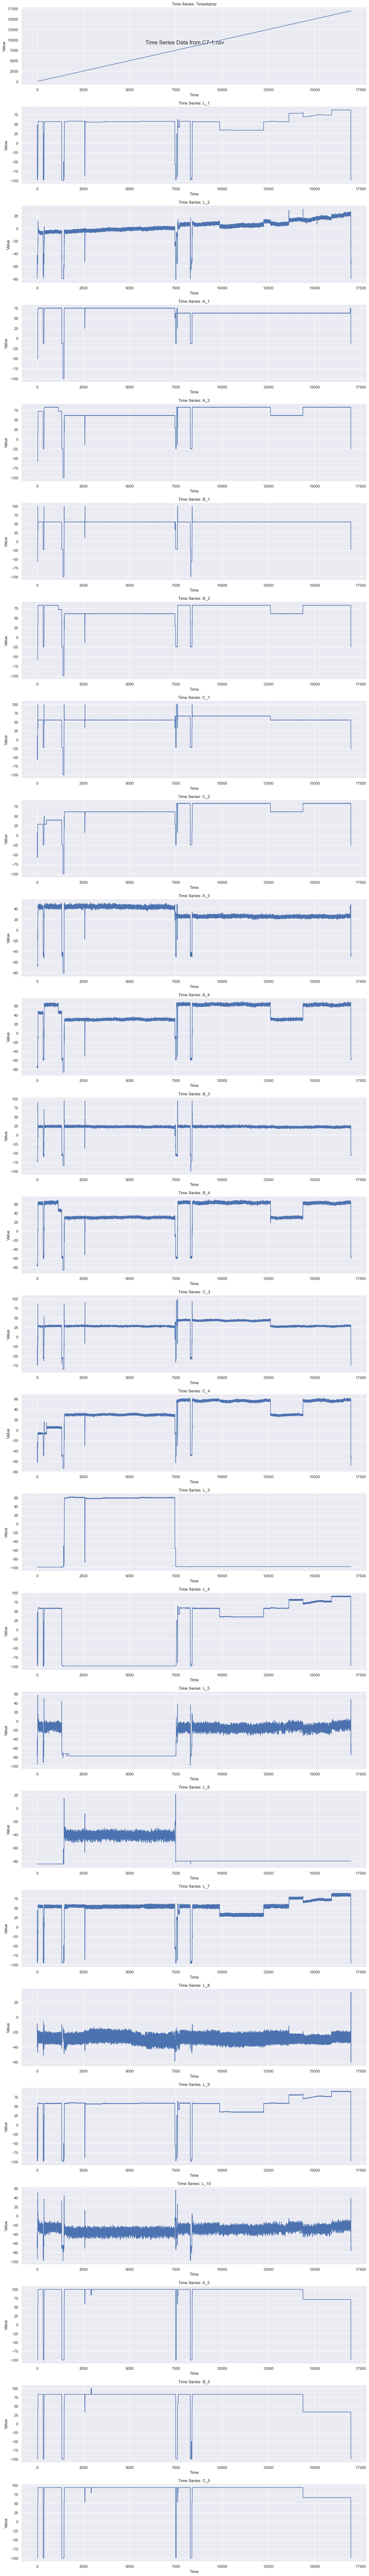

In [4]:
# Create a figure with subplots for each numerical column
numerical_cols = df.select_dtypes(include=[np.number]).columns
n_cols = len(numerical_cols)
fig, axes = plt.subplots(n_cols, 1, figsize=(15, 4*n_cols))
fig.suptitle('Time Series Data from C7-1.csv', fontsize=16)

for i, col in enumerate(numerical_cols):
    if n_cols == 1:
        ax = axes
    else:
        ax = axes[i]
    
    df[col].plot(ax=ax)
    ax.set_title(f'Time Series: {col}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.grid(True)

plt.tight_layout()
plt.show()

<font color='teal'>**Set your working directory correctly**</font>

In [3]:
os.getcwd()

'C:\\Users\\Bauyrjan.Jyenis\\Capstone2_Project\\capstone\\models'

In [4]:
path = 'C:\\Users\\Bauyrjan.Jyenis\\Capstone2_Project\\capstone\\data\\raw'
os.chdir(path)

<font color='teal'>**Read the CSV file into pandas dataframes**</font>

In [8]:
df = pd.read_csv('sensor.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

In [9]:
df.shape

(220320, 55)

In [10]:
df.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [11]:
df.tail()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
220315,220315,2018-08-31 23:55:00,2.407350,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,...,38.28125,68.28703,52.37268,48.32176,41.087960,212.3843,153.6458,NaN,231.1921,NORMAL
220316,220316,2018-08-31 23:56:00,2.400463,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,...,38.28125,66.84028,50.63657,48.03241,40.798610,213.8310,156.2500,NaN,231.1921,NORMAL
220317,220317,2018-08-31 23:57:00,2.396528,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,...,39.06250,65.39352,48.90046,48.03241,40.798610,217.3032,155.3819,NaN,232.0602,NORMAL
220318,220318,2018-08-31 23:58:00,2.406366,47.69965,50.520832,43.142361,635.648100,65.09175,15.11863,16.56539,...,40.62500,64.23611,47.74306,48.32176,40.509258,222.5116,153.9352,NaN,234.0856,NORMAL
220319,220319,2018-08-31 23:59:00,2.396528,47.69965,50.520832,43.142361,639.814800,65.45634,15.11863,16.65220,...,41.40625,62.78935,46.29630,48.90046,40.219910,227.4306,150.4630,NaN,234.0856,NORMAL


In [12]:
del df['Unnamed: 0']

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 54 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   timestamp       220320 non-null  object 
 1   sensor_00       210112 non-null  float64
 2   sensor_01       219951 non-null  float64
 3   sensor_02       220301 non-null  float64
 4   sensor_03       220301 non-null  float64
 5   sensor_04       220301 non-null  float64
 6   sensor_05       220301 non-null  float64
 7   sensor_06       215522 non-null  float64
 8   sensor_07       214869 non-null  float64
 9   sensor_08       215213 non-null  float64
 10  sensor_09       215725 non-null  float64
 11  sensor_10       220301 non-null  float64
 12  sensor_11       220301 non-null  float64
 13  sensor_12       220301 non-null  float64
 14  sensor_13       220301 non-null  float64
 15  sensor_14       220299 non-null  float64
 16  sensor_15       0 non-null       float64
 17  sensor_16 

#### 2.3 - Initial Exploratory Data Analysis

- Count of unique values
- Numeric columns
- Missing values
- Summary stats
- Outliers
    - Considerably higher or lower
    - Require further investigation

In [14]:
df.nunique()

timestamp         220320
sensor_00           1253
sensor_01            831
sensor_02            831
sensor_03            588
sensor_04           7844
sensor_05         190751
sensor_06            812
sensor_07            531
sensor_08            626
sensor_09            565
sensor_10         198804
sensor_11         196368
sensor_12         187145
sensor_13         191983
sensor_14          94564
sensor_15              0
sensor_16         110522
sensor_17         148000
sensor_18         152603
sensor_19         100422
sensor_20          92129
sensor_21         131083
sensor_22         126401
sensor_23         119286
sensor_24         133778
sensor_25         165999
sensor_26         179718
sensor_27         203198
sensor_28         189278
sensor_29         201908
sensor_30           2070
sensor_31           2685
sensor_32         205414
sensor_33         200855
sensor_34         203895
sensor_35         201781
sensor_36         201437
sensor_37         188898
sensor_38            602


There are two variables, "sensor_15" and "machine_status", I am interested in looking at closely

In [15]:
# Let's count the unique values of one of the columns
df['machine_status'].value_counts(dropna=False).head()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

In [16]:
# Let's count the unique values of one of the columns
df['sensor_15'].value_counts(dropna=False).head()

NaN    220320
Name: sensor_15, dtype: int64

<font color='teal'>**Let's look at the summary statistics on the remaining columns**</font>

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sensor_00,210112.0,2.372221,0.412227,0.000000,2.438831,2.456539,2.499826,2.549016
sensor_01,219951.0,47.591611,3.296666,0.000000,46.310760,48.133678,49.479160,56.727430
sensor_02,220301.0,50.867392,3.666820,33.159720,50.390620,51.649300,52.777770,56.032990
sensor_03,220301.0,43.752481,2.418887,31.640620,42.838539,44.227428,45.312500,48.220490
sensor_04,220301.0,590.673936,144.023912,2.798032,626.620400,632.638916,637.615723,800.000000
sensor_05,220301.0,73.396414,17.298247,0.000000,69.976260,75.576790,80.912150,99.999880
sensor_06,215522.0,13.501537,2.163736,0.014468,13.346350,13.642940,14.539930,22.251160
sensor_07,214869.0,15.843152,2.201155,0.000000,15.907120,16.167530,16.427950,23.596640
sensor_08,215213.0,15.200721,2.037390,0.028935,15.183740,15.494790,15.697340,24.348960
sensor_09,215725.0,14.799210,2.091963,0.000000,15.053530,15.082470,15.118630,25.000000


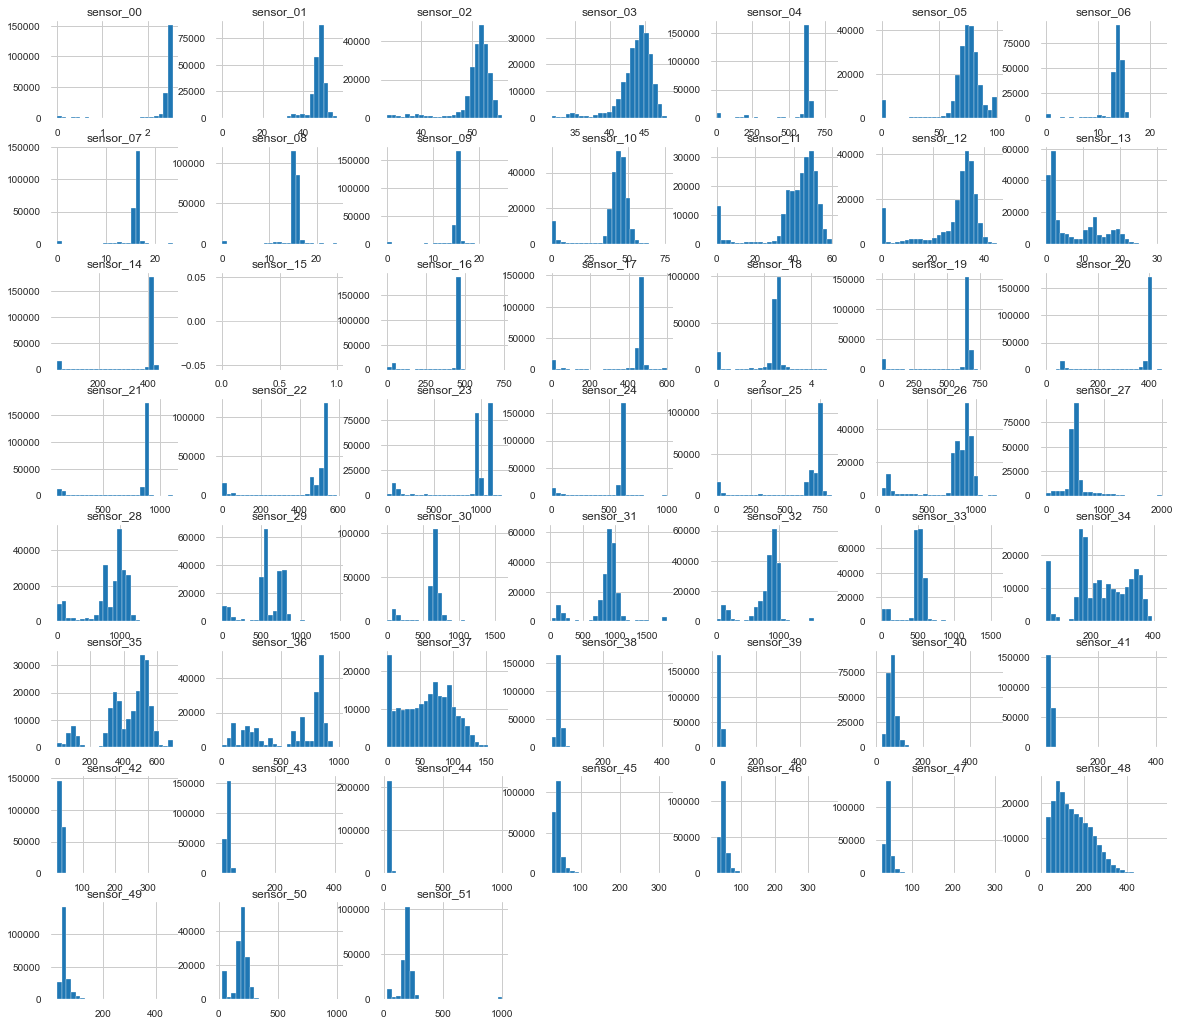

In [16]:
# Histogram
df.hist(df.columns, bins=25, layout=(8,7), figsize=(20, 18))
plt.show()

#### 2.3 - Clean the data
- Remove redundant columns
- Remove duplicates
- Handle missing values
- Convert data types to the correct data type

Keep in mind: there are data formats that are better for reporting vs. better for analysis; tidy data makes it easier to fix common data problems

<font color='teal'>**Remove duplicates from the dataframe**</font>

In [17]:
# Drop duplicates
df = df.drop_duplicates()

In [18]:
df.shape

(220320, 54)

<font color='teal'>**Handle Missing Values**</font>

In [19]:
# Entire "sensor_15" column is NaN therefore removing the entire column from the data set
del df['sensor_15']

In [20]:
df.shape

(220320, 53)

In [21]:
# Function that calculates the percentage of missing values
def calc_percent_NAs(df):
    nans = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df), columns=['percent']) 
    idx = nans['percent'] > 0
    return nans[idx]

In [22]:
# Let's take a look at top ten columns with missing values
calc_percent_NAs(df).head(10)

,percent
sensor_50,0.349569
sensor_51,0.069821
sensor_00,0.046333
sensor_07,0.024741
sensor_08,0.023180
sensor_06,0.021777
sensor_09,0.020856
sensor_01,0.001675
sensor_30,0.001185
sensor_29,0.000327


In [23]:
df[['sensor_50', 'sensor_51', 'sensor_00', 'sensor_07', 'sensor_08', 'sensor_06', 'sensor_09']].describe().T

,count,mean,std,min,25%,50%,75%,max
sensor_50,143303.0,183.049260,65.258650,27.488426,167.534700,193.865700,219.907400,1000.000000
sensor_51,204937.0,202.699667,109.588607,27.777779,179.108800,197.338000,216.724500,1000.000000
sensor_00,210112.0,2.372221,0.412227,0.000000,2.438831,2.456539,2.499826,2.549016
sensor_07,214869.0,15.843152,2.201155,0.000000,15.907120,16.167530,16.427950,23.596640
sensor_08,215213.0,15.200721,2.037390,0.028935,15.183740,15.494790,15.697340,24.348960
sensor_06,215522.0,13.501537,2.163736,0.014468,13.346350,13.642940,14.539930,22.251160
sensor_09,215725.0,14.799210,2.091963,0.000000,15.053530,15.082470,15.118630,25.000000


Let's fill NAs in columns sensor_50, sensor_51, sensor_00, sensor_07, sensor_08, sensor_06 and sensor_09 with their mean values as they are 1% of the entire data set. The rest of the columns with NaNs will be removed from the data set.

In [24]:
df['sensor_50'].fillna((df['sensor_50'].mean()), inplace=True)
df['sensor_51'].fillna((df['sensor_51'].mean()), inplace=True)
df['sensor_00'].fillna((df['sensor_00'].mean()), inplace=True)
df['sensor_08'].fillna((df['sensor_08'].mean()), inplace=True)
df['sensor_07'].fillna((df['sensor_07'].mean()), inplace=True)
df['sensor_06'].fillna((df['sensor_06'].mean()), inplace=True)
df['sensor_09'].fillna((df['sensor_09'].mean()), inplace=True)

In [25]:
# Let's take a look at top ten columns with missing values
calc_percent_NAs(df).head(10)

,percent
sensor_01,0.001675
sensor_30,0.001185
sensor_29,0.000327
sensor_32,0.000309
sensor_18,0.000209
sensor_17,0.000209
sensor_22,0.000186
sensor_25,0.000163
sensor_16,0.000141
sensor_40,0.000123


In [26]:
df_tidy = df.dropna()

<font color='teal'>**Convert data types to the correct data type**</font>

In [27]:
# Let's convert the data type of timestamp column to datatime format
import warnings
warnings.filterwarnings("ignore")
df_tidy['date'] = pd.to_datetime(df_tidy['timestamp'])
del df_tidy['timestamp']

In [31]:
df_tidy = df_tidy.set_index('date')
df_tidy.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
date,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [32]:
df_tidy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 219521 entries, 2018-04-01 00:00:00 to 2018-08-31 23:59:00
Data columns (total 52 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   sensor_00       219521 non-null  float64
 1   sensor_01       219521 non-null  float64
 2   sensor_02       219521 non-null  float64
 3   sensor_03       219521 non-null  float64
 4   sensor_04       219521 non-null  float64
 5   sensor_05       219521 non-null  float64
 6   sensor_06       219521 non-null  float64
 7   sensor_07       219521 non-null  float64
 8   sensor_08       219521 non-null  float64
 9   sensor_09       219521 non-null  float64
 10  sensor_10       219521 non-null  float64
 11  sensor_11       219521 non-null  float64
 12  sensor_12       219521 non-null  float64
 13  sensor_13       219521 non-null  float64
 14  sensor_14       219521 non-null  float64
 15  sensor_16       219521 non-null  float64
 16  sensor_17       219521

<font color='teal'>**Handling outliers**</font>

The proper action towards handling outliers depends on what causes the outliers. In broad strokes, there are three causes for outliers—data entry or measurement errors, sampling problems and unusual conditions, and natural variation. Since the purpose of this study is focused on anomaly detection, we need to be really careful about how to handle outliers as opposed to just removing them from the dataset. The outliers may represent unusual conditions which may represent the anomalies we are looking for. With that, let's keep the outliers for now and look at them more closely in the next step.

<font color='teal'>**Let's export the tidy data into a CSV file to be used in next steps**</font>

In [33]:
path = 'C:\\Users\\Bauyrjan.Jyenis\\Capstone2_Project\\capstone\\data\\processed'
os.chdir(path)

In [34]:
# Write the dataframe to csv 
df_tidy.to_csv('step2-output.csv')